In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
import os

In [2]:
# example mean reversion strategy taking the mean of the last day

# move up a directory
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)
print("Working directory:", os.getcwd())

# load tapes data
from fast_tools import readc_day, get_dates

dates = get_dates()
level2_data = []
for d in dates:
    lob_data, lob_times, tapes = readc_day(d)
    level2_data.append({"LOB": lob_data,
                        "LOB_t": lob_times,
                        "Tapes": tapes})

# move down a directory
os.chdir(current_directory)

Working directory: c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19


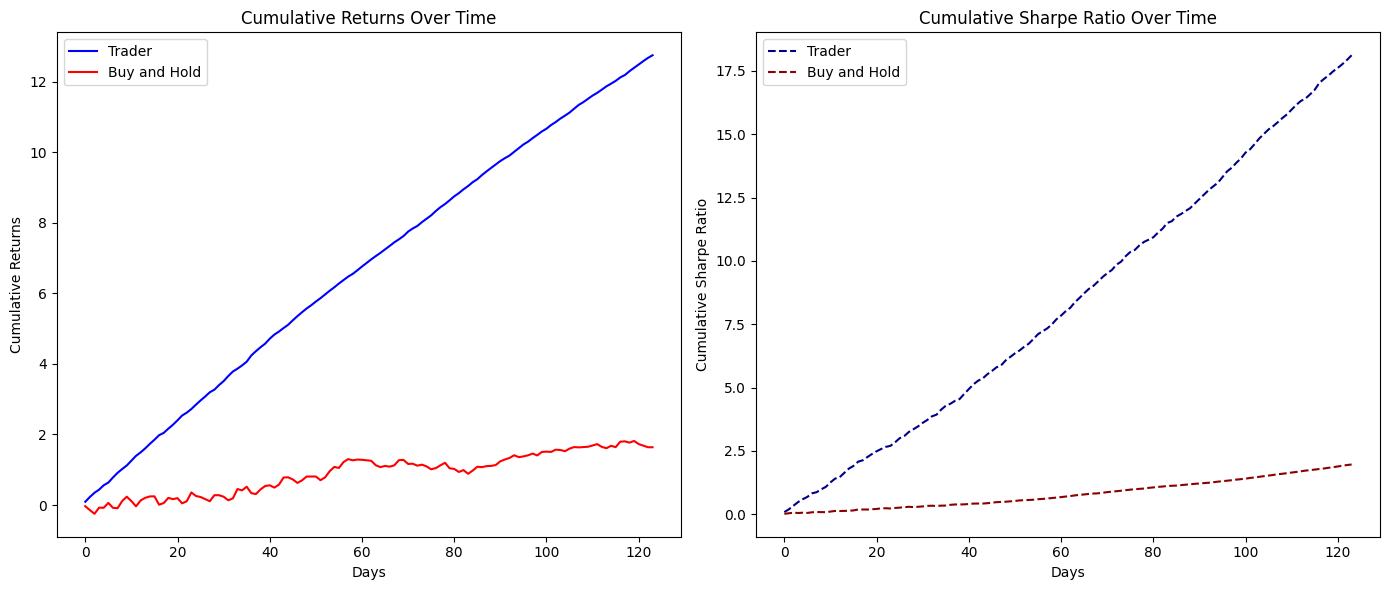

In [16]:
def display_performance(results):

    # Assuming results is a list containing trader_performance, buy_and_hold_performance, sharpe_trader, and sharpe_buy_and_hold
    trader_performance = np.array(results[0])
    buy_and_hold_performance = np.array(results[1])
    sharpe_trader = results[2]
    sharpe_buy_and_hold = results[3]

    # Calculate cumulative returns
    trader_cumulative_returns = np.cumsum(trader_performance)
    buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_performance)

    # Create time axis
    x = np.arange(len(trader_performance))

    # Create cumulative Sharpe ratios
    cumulative_sharpe_trader = np.cumsum(sharpe_trader)
    cumulative_sharpe_buy_and_hold = np.cumsum(sharpe_buy_and_hold)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot cumulative returns on the first subplot
    axs[0].plot(x, trader_cumulative_returns, label='Trader', color='blue')
    axs[0].plot(x, buy_and_hold_cumulative_returns, label='Buy and Hold', color='red')
    axs[0].set_ylabel('Cumulative Returns')
    axs[0].set_xlabel('Days')
    axs[0].set_title('Cumulative Returns Over Time')
    axs[0].legend()

    # Plot cumulative Sharpe ratios on the second subplot
    axs[1].plot(x, cumulative_sharpe_trader, label='Trader', color='darkblue', linestyle='--')
    axs[1].plot(x, cumulative_sharpe_buy_and_hold, label='Buy and Hold', color='darkred', linestyle='--')
    axs[1].set_ylabel('Cumulative Sharpe Ratio')
    axs[1].set_xlabel('Days')
    axs[1].set_title('Cumulative Sharpe Ratio Over Time')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

def agg_data(level2_data, time_step_s):
    agg_list = []
    n_rows = int((8.5 * 60 * 60) / time_step_s)  
    for level2_day in level2_data:

    return agg_list

import math
    
class Mean_Rev():
    def __init__(self, training_data, test_data):
        self.mean = (training_data["Price"] * training_data["Volume"]).sum() / training_data["Volume"].sum()
        test_prices = test_data["Price"].to_numpy()

        n = len(test_data)
        self.indicators = np.zeros(n)
        for i in range(n - 1):
            self.indicators[i] = (test_prices[i] < self.mean) * 2 - 1

    def action(self, index):
        return self.indicators[index]
    
class Mean_MA_trained():
    def __init__(self, training_data, test_data):
        test_prices = test_data["Price"].to_numpy()
        training_prices = training_data["Price"].to_numpy()
        # optimise window parameter
        max_window_value = math.log(len(training_prices), 1.6) // 1
        window_values = (1.6 ** (np.arange(max_window_value)[1:])).astype(int)
        
        scores = []
        for w in window_values:
            w_series = training_data["Price"].rolling(w).mean().to_numpy()
            scores.append(abs(0.5 - np.mean(w_series[w:] > training_prices[w:])))

        optimal_w = window_values[np.argmin(scores)]
        # build indicator

        n = len(test_data)
        self.indicators = np.zeros(n)
        window = optimal_w
        MA_series = test_data["Price"].rolling(window).mean().to_numpy()
        for i in range(n - window):
            MA = MA_series[i+window - 1]
            self.indicators[i+window - 1] = (test_prices[i+window - 1] < MA) * 2 - 1

    def action(self, index):
        return self.indicators[index]
    
class GAP_agent():
    def __init__(self, training_data, test_data) -> None:
        pass

def test_strategy_tapes(agent, level2_data: list[dict], time_step_s = 60, starting_cash = 10_000):
    # aggregate the data


    tapes = agg_data(level2_data, time_step_s)
    N = len(tapes)

    buy_and_hold_profits = []
    agent_profits = []
    agent_sharpe = []
    buy_and_hold_sharpe = []
    agent_daily_values = []
    for day_i in range(N-1):

        print(f"Day {day_i}", end = "\r")
        prev_day = tapes[day_i]
        curr_day = tapes[day_i + 1]

        Agent = agent(prev_day, curr_day)

        
        cash = starting_cash
        assets = 0
        c = 0
        agent_value = []
        for i, row in curr_day.iterrows():
            action = Agent.action(c)

            if action == 1:
                price = row["Price"]
                if cash > price:
                    cash -= price
                    assets += 1

            elif action == -1:
                price = row["Price"]
                if assets > 0:
                    assets -= 1
                    cash += price
            else:
                pass

            agent_value.append(cash + assets * row["Price"])
            c += 1

        agent_return = (agent_value[-1] - starting_cash) / starting_cash
        agent_profits.append(agent_return)
        day_return = (curr_day.iloc[0]["Price"] / curr_day.iloc[-1]["Price"]) - 1
        buy_and_hold_profits.append(day_return)
        agent_daily_values.append(agent_value)


        RF_rate = 0
        if agent_return == 0:
            agent_sharpe.append(0)
        else:
            agent_value = np.array(agent_value)
            ex_returns = (np.diff(agent_value) / agent_value[:-1]) - RF_rate
            agent_sharpe.append(np.mean(ex_returns) / np.std(ex_returns))

        ex_returns = curr_day["Price"].pct_change() - RF_rate
        buy_and_hold_sharpe.append(np.mean(ex_returns) / np.std(ex_returns))

    return agent_profits, buy_and_hold_profits, agent_sharpe, buy_and_hold_sharpe, agent_daily_values

results = test_strategy_tapes(, level2_data)
display_performance(results)

c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-i

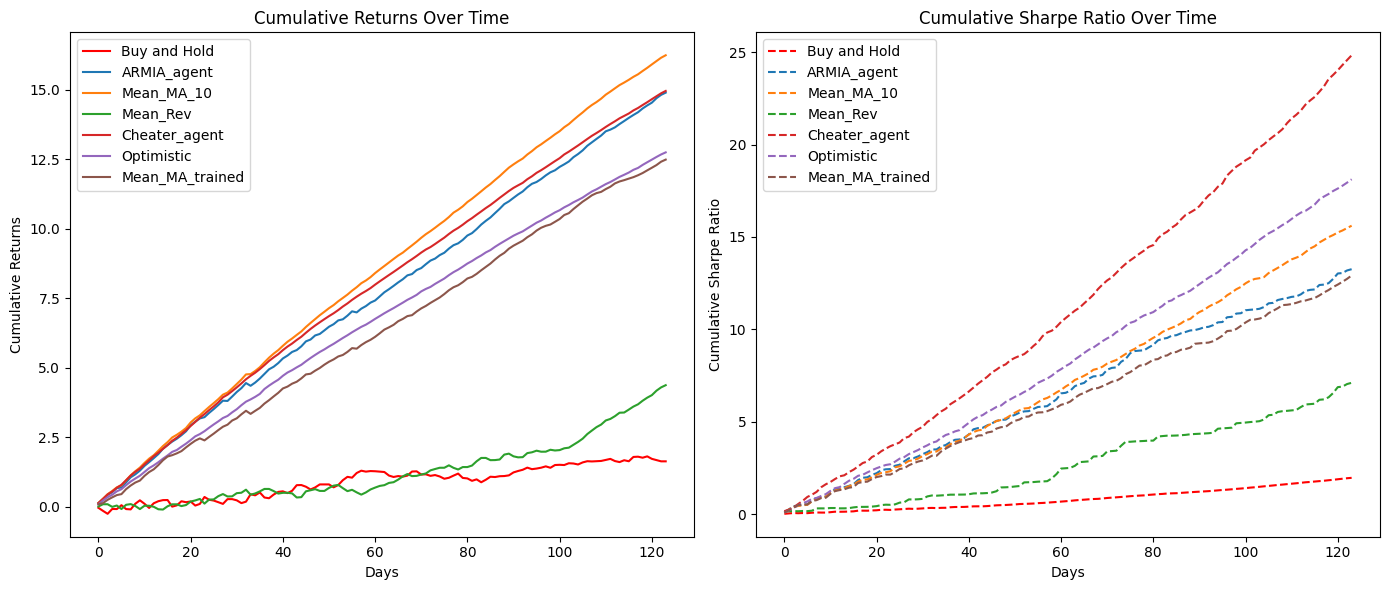

In [13]:
from statsmodels.tsa.arima.model import ARIMA

class ARMIA_agent():
    def __init__(self, training_data, test_data):
        n = len(test_data)
        self.indicators = np.zeros(n)
        test_prices = test_data["Price"].to_numpy()

        model = ARIMA(training_data["Price"], order=(1,0,1))
        result = model.fit()
        result2 = result.apply(test_data["Price"], refit=False)
        pred2 = np.array(result2.predict(start=0, end=n-1))

        for i in range(n - 1):
            if pred2[i] > test_prices[i]: # use one step behind as there is no inital prediction
                self.indicators[i] = 1
            else:
                self.indicators[i] =  -1

    def action(self, index):
        return self.indicators[index]
    
class Cheater_agent():
    def __init__(self, training_data, test_data):
        n = len(test_data)
        self.indicators = np.zeros(n)
        test_prices = test_data["Price"].to_numpy()

        for i in range(n - 1):
            if test_prices[i+1] > test_prices[i]:
                self.indicators[i] = 1 
            else:
                self.indicators[i] =  -1

    def action(self, index):
        return self.indicators[index]
    
def compare_agents(agents: list, raw_tapes):
    num_agents = len(agents)
    all_results = []
    for agent in agents:
        all_results.append(test_strategy(agent, raw_tapes, "1min", 10_000))

    # Assuming results is a list containing trader_performance, buy_and_hold_performance, sharpe_trader, and sharpe_buy_and_hold
    buy_and_hold_performance = all_results[0][1]
    sharpe_buy_and_hold = all_results[0][3]

    # Calculate cumulative returns
    buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_performance)

    # Create time axis
    x = np.arange(len(buy_and_hold_performance))

    # Create cumulative Sharpe ratios
    cumulative_sharpe_buy_and_hold = np.cumsum(sharpe_buy_and_hold)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot cumulative returns on the first subplot
    axs[0].plot(x, buy_and_hold_cumulative_returns, label='Buy and Hold', color='red')

    for i in range(num_agents):
        trader_performance = all_results[i][0]
        trader_cumulative_returns = np.cumsum(trader_performance)
        axs[0].plot(x, trader_cumulative_returns, label=agents[i].__name__)

    axs[0].set_ylabel('Cumulative Returns')
    axs[0].set_xlabel('Days')
    axs[0].set_title('Cumulative Returns Over Time')
    axs[0].legend()

    # Plot cumulative Sharpe ratios on the second subplot
    axs[1].plot(x, cumulative_sharpe_buy_and_hold, label='Buy and Hold', color='red', linestyle='--')

    for i in range(num_agents):
        sharpe_trader = all_results[i][2]
        trader_cumulative_returns = np.cumsum(trader_performance)
        cumulative_sharpe_trader = np.cumsum(sharpe_trader)
        axs[1].plot(x, cumulative_sharpe_trader, label=agents[i].__name__, linestyle='--')

    axs[1].set_ylabel('Cumulative Sharpe Ratio')
    axs[1].set_xlabel('Days')
    axs[1].set_title('Cumulative Sharpe Ratio Over Time')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

compare_agents([ARMIA_agent, Mean_MA_10, Mean_Rev, Cheater_agent, Optimistic, Mean_MA_trained], raw_tapes)